## Rather than the Reactor, we will now try with the NARMA Task ##

In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2, FakeProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob
import pickle as pkl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC,  QRewindingRC_Neat
from src.data import DataSource

from iqm.qiskit_iqm import IQMFakeAdonis
from iqm.qiskit_iqm import IQMProvider,transpile_to_IQM

server_url = "https://cocos.resonance.meetiqm.com/garnet"  # For example https://cocos.resonance.meetiqm.com/garnet
api_token = "w8yFvWKCBEj26UGLs6H/OpoPgJtyzhT05Qj89TTyWXsGa9IttUZ494AAS29Z0Cju"

SHOTS = 8000

backend = IQMProvider(server_url, token=api_token).get_backend()


In [2]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':False, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'ridge', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              'file_name':'New_Class_Testing_no_x',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters


new_class_test= QRewindingRC_Neat(**fulldict)
data = data = DataSource(nepisodes=2, xtype='narma_seq', ytype='narma2', memory=2,xnorm='scale',ynorm='scale', rseed_data=0)
new_class_test.prepare(data)

IQM
Using Hard-coded layout


In [12]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                               # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'add_y_to_input':True,
                         'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.
                         
    
    
    
    'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':False, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'ridge', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              'file_name':'Narma_Testing',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters


In [11]:
data.ymin_nonorm

[0.19104554168986349]

In [8]:
new_class_test.use_unnormed_error_metrics = False

In [10]:
new_class_test.train(resume=False)

transpiled circuits 0.5
saved circuits


In [11]:
new_class_test.mse_train

0.012288919106996777

In [12]:
new_class_test.reinterpret_with_inputs()

Loaded counts from file


In [13]:
new_class_test.mse_train

0.00025819696093874506

In [14]:
new_class_test.reinterpret_only_inputs()

Loaded counts from file


In [15]:
new_class_test.mse_train

0.000591884155722247

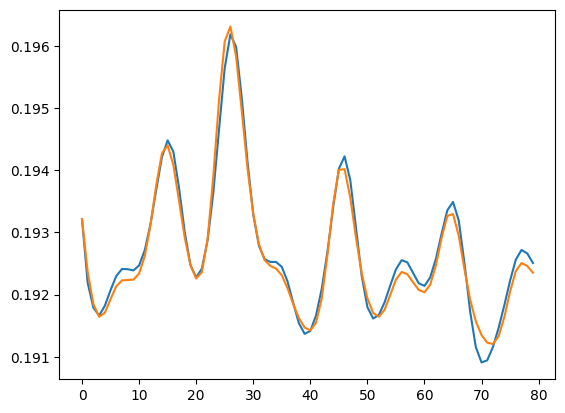

In [17]:
plt.plot(new_class_test.ytrain_nonorm[0])
plt.plot(new_class_test.data.ytrain_nonorm[0])

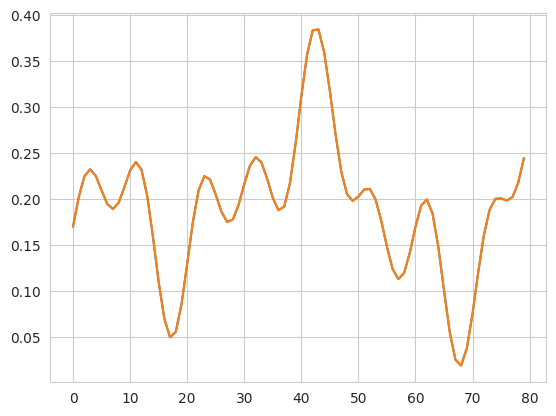

In [20]:
plt.plot(range(80),new_class_test.xtrain[0])
plt.plot(range(80),new_class_test.data.xtrain[0])

In [22]:
new_class_test.train(resume=False)
print('res only train',np.sqrt(new_class_test.mse_train))

new_class_test.val(resume=False)
print('res only val',np.sqrt(new_class_test.mse_val))

# With inputs:
new_class_test.reinterpret_with_inputs()
print('res + inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_with_inputs(resume=False)
print('res + inputs val',np.sqrt(new_class_test.mse_val))

# only inputs:
new_class_test.reinterpret_only_inputs()
print('only inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_only_inputs(resume=False)
print('only inputs val',np.sqrt(new_class_test.mse_val))

transpiled circuits 0.5
saved circuits
res only train 0.0012764182241905141
res only train 0.0011716269349331505
Loaded counts from file
res + inputs train 0.0007257516974919647
res + inputs val 0.0006441197031190394
Loaded counts from file
only inputs train 0.0007917522899640573
only inputs val 0.0006391943654104915


In [23]:
new_class_test.reinterpret_with_inputs()
print('res + inputs train',np.sqrt(new_class_test.mse_train))

Loaded counts from file
res + inputs train 0.0007257516974919647


In [31]:
np.round(new_class_test.weights.coef_,2)

array([[-0.  ,  0.  , -0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  , -0.  ,
        -0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,
        -0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  , -0.  ,
         0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,
         0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  , -0.  ,
        -0.  , -0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  ,
         0.  ,  0.  ,  0.  , -0.  ,  0.  , -0.  , -0.  ,  0.  , -0.  ,
         0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  ,  0.  , -0.  ,  0.  ,
        -0.  , -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  , -0.  ,
         0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,
        -0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  , -0.  ,  0.  ,
         0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,
         0.01,  0.  ]])

In [34]:
np.round(new_class_test.weights.coef_,2).shape

(1, 110)

In [36]:
new_class_test.train(resume=False)
print('res only train',np.sqrt(new_class_test.mse_train))
print(np.round(new_class_test.weights.coef_,2))
print(np.round(new_class_test.weights.coef_,2).shape)

transpiled circuits 0.5
saved circuits
res only train 0.0012775831517508108
[[ 0.   -0.   -0.   -0.   -0.   -0.   -0.    0.    0.   -0.    0.   -0.
   0.   -0.   -0.   -0.    0.   -0.   -0.    0.   -0.    0.   -0.   -0.
  -0.    0.   -0.   -0.    0.    0.    0.   -0.   -0.    0.    0.   -0.
  -0.    0.   -0.    0.    0.   -0.    0.   -0.   -0.   -0.   -0.   -0.
   0.    0.    0.   -0.    0.    0.    0.   -0.   -0.    0.   -0.    0.
   0.   -0.    0.    0.   -0.   -0.   -0.   -0.01 -0.    0.    0.    0.
  -0.    0.   -0.   -0.    0.   -0.   -0.    0.   -0.   -0.    0.   -0.
   0.    0.   -0.    0.   -0.    0.   -0.   -0.   -0.   -0.    0.   -0.
  -0.    0.   -0.   -0.    0.   -0.02]]
(1, 102)


In [2]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                               # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'add_y_to_input':False,
                         'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.
                         
    
    
    
    'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':2, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':False, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'ridge', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              'file_name':'Narma_Testing',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters

new_class_test= QRewindingRC_Neat(**fulldict)
data = data = DataSource(nepisodes=2, xtype='narma_smooth', ytype='narma2', memory=2, rseed_data=0)
new_class_test.prepare(data)

IQM
Using Hard-coded layout


In [67]:
new_class_test.train(resume=False)
print('res only train',np.sqrt(new_class_test.mse_train))

new_class_test.val(resume=False)
print('res only val',np.sqrt(new_class_test.mse_val))

# With inputs:
new_class_test.reinterpret_with_inputs()
print('res + inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_with_inputs(resume=False)
print('res + inputs val',np.sqrt(new_class_test.mse_val))

# only inputs:
new_class_test.reinterpret_only_inputs()
print('only inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_only_inputs(resume=False)
print('only inputs val',np.sqrt(new_class_test.mse_val))

transpiled circuits 0.5
saved circuits
res only train 0.0012462291226935608
res only val 0.0010977538889634375
Loaded counts from file
res + inputs train 0.0007094730650150614
res + inputs val 0.000644435619610456
Loaded counts from file
only inputs train 0.0007932266019954557
only inputs val 0.0006393843023182053


In [42]:
np.round(new_class_test.weights.coef_,2)

(1, 106)

In [44]:
new_class_test.__dict__.keys()

dict_keys(['simulate', 'manual', 'confirm', 'rseed', 'log', 'washout', 'washout_eff', 'add_x_as_feature', 'nyfuture', 'delete_future_y', 'fitter', 'regression_model', 'regression_alpha', 'regression_l1', 'poly_degree', 'mse_val', 'mse_train', 'mape_val', 'mape_train', 'nrmse_val', 'nrmse_train', 'traintime', 'data', 'dimx', 'dimy', 'xmax', 'xmin', 'nepisodes', 'dimf', 'weights', 'xtrain', 'xval', 'ftrain', 'fval', 'ytrain', 'yval', 'ytrain_nonorm', 'yval_nonorm', 'use_unnormed_error_metrics', 'qc', 'dimxqc', 'dimx_wo_copies', 'qctype', 'qinit', 'enctype', 'encangle', 'ftype', 'nqubits', 'nenccopies', 'measaxes', 'encaxes', 'shots', 'nlayers', 'backend', 't1', 'sim_method', 'sim', 'sim_precision', 'quni', 'qin', 'qmeas', 'ngates', 'unistep', 'ising_t', 'ising_jmax', 'ising_h', 'ising_wmax', 'ising_random', 'ising_jpositive', 'ising_wpositive', 'preloading', 'mtype', 'minc', 'mend', 'nmeas', 'resetm', 'reseti', 'weak_angle', 'poly_feat', 'xyoffset', 'set_past_y_to_0', 'use_true_y_in_val'

In [45]:
new_class_test.add_y_to_input

False

In [56]:
new_class_test.set_past_y_to_0

False

In [47]:
new_class_test.lookback_max

False

In [63]:
[xe_lookback,ye_lookback]=new_class_test._init_t_inputs(
                x0=new_class_test.data.xtrain[0][0], y0=new_class_test.data.ytrain[0][0], 
                steps_max=200)
xlookback=new_class_test.xlookback
ylookback=new_class_test.ylookback

In [65]:
x0 = new_class_test._policy(0, e=0, step=0, train=True, offset=1)
# save current input
xe_lookback[t_in+xlookback-1] = x0

#means the episode has come to an end.

#We also save future y values:
y1 = new_class_test.data.ytrain[0][1]
# save current ouput
ye_lookback[0+ylookback] = y1 

#Get the input to encode for both x and y.
input_t = new_class_test._get_input_t(xe_lookback=xe_lookback, ye_lookback=ye_lookback, t_pred=1, t_in=0)

In [66]:
input_t

array([[0.17007865],
       [0.17007865],
       [0.17007865],
       [0.17007865]])

In [58]:
new_class_test.xyoffset

1

In [68]:
new_class_test.weights.coef_

array([[0.00386201, 0.00401735, 0.00576639, 0.00826793]])

In [79]:
new_class_test.weights.__dict__

{'alpha': 0.1,
 'fit_intercept': True,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.0001,
 'solver': 'auto',
 'positive': False,
 'random_state': None,
 'n_features_in_': 4,
 'coef_': array([[0.00386201, 0.00401735, 0.00576639, 0.00826793]]),
 'n_iter_': None,
 'intercept_': array([0.18853888])}

In [80]:
prediction=0.00386201*new_class_test.xtrain[0][0:77]+0.00401735*new_class_test.xtrain[0][1:78] + 0.00576639*new_class_test.xtrain[0][2:79] + 0.00826793 * new_class_test.xtrain[0][3:80] + 0.18853888

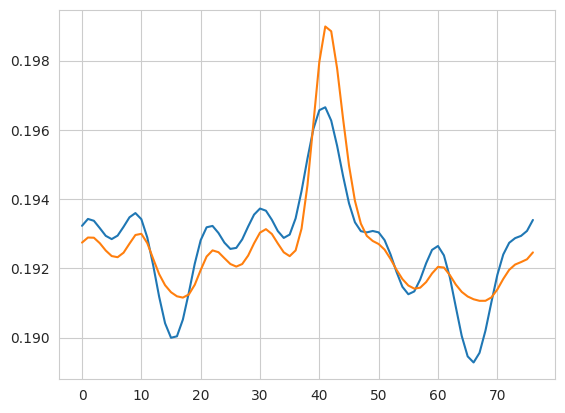

In [82]:
plt.plot(range(77),prediction)
plt.plot(range(77),new_class_test.data.ytrain[0][3:])

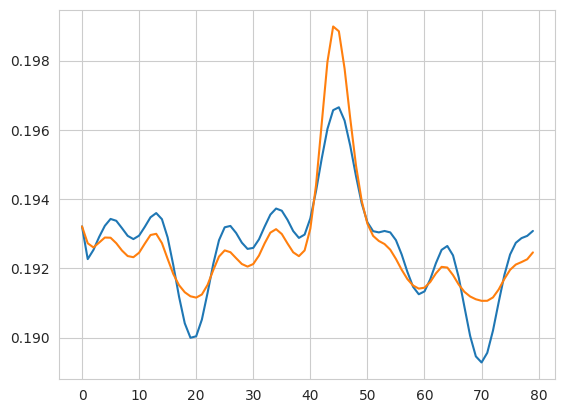

In [83]:
plt.plot(range(80),new_class_test.ytrain[0])
plt.plot(range(80),new_class_test.data.ytrain[0])

In [3]:
data = DataSource(nepisodes=2, xtype='narma_smooth', ytype='narma2', memory=2, rseed_data=0,xnorm='std',ynorm='std')
new_class_test.prepare(data)

Mean: 0.099567, StandardDeviation: 0.035614
Mean: 0.192841, StandardDeviation: 0.001545
Using Hard-coded layout


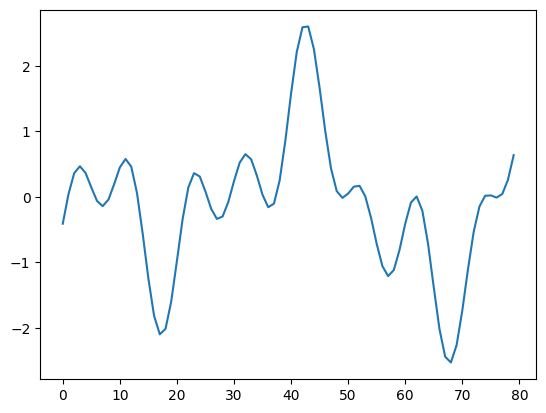

In [5]:
plt.plot(new_class_test.data.xtrain[0])

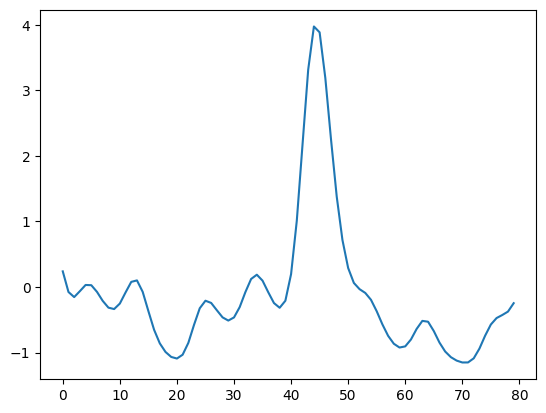

In [6]:
plt.plot(new_class_test.data.ytrain[0])

In [5]:
new_class_test.xmax

[2.7499161551753546]

In [6]:
new_class_test.train(resume=False)
print('res only train',np.sqrt(new_class_test.mse_train))

new_class_test.val(resume=False)
print('res only val',np.sqrt(new_class_test.mse_val))

# With inputs:
new_class_test.reinterpret_with_inputs()
print('res + inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_with_inputs(resume=False)
print('res + inputs val',np.sqrt(new_class_test.mse_val))

# only inputs:
new_class_test.reinterpret_only_inputs()
print('only inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_only_inputs(resume=False)
print('only inputs val',np.sqrt(new_class_test.mse_val))

transpiled circuits 0.5
saved circuits
res only train 0.42915438362537056
res only val 0.35930741646613223
Loaded counts from file
res + inputs train 1.095627945487979
res + inputs val 0.9592136433982166
Loaded counts from file
only inputs train 1.0407447694938456
only inputs val 0.8570020497300374


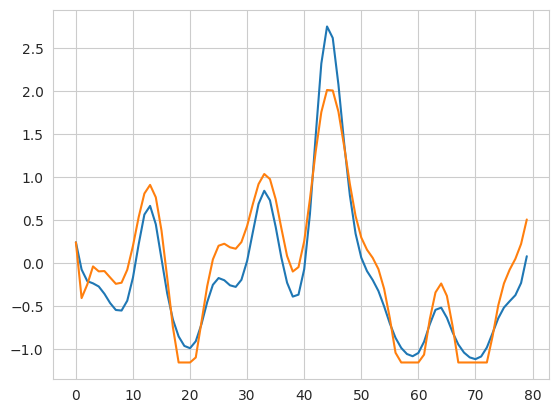

In [10]:
plt.plot(new_class_test.data.yval[0])
plt.plot(new_class_test.yval[0])

In [2]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                               # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'add_y_to_input':True,
                         'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.
                         
    
    
    
    'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':False, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'ridge', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              'file_name':'Narma_Testing',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters

new_class_test= QRewindingRC_Neat(**fulldict)
data = DataSource(nepisodes=2, xtype='narma_smooth', ytype='narma2', memory=2, rseed_data=0,xnorm='std',ynorm='std')
new_class_test.prepare(data)


IQM
Mean: 0.099567, StandardDeviation: 0.035614
Mean: 0.192841, StandardDeviation: 0.001545
Using Hard-coded layout


In [24]:
new_class_test.train(resume=False)
print('res only train',np.sqrt(new_class_test.mse_train))

new_class_test.val(resume=False)
print('res only val',np.sqrt(new_class_test.mse_val))

# With inputs:
new_class_test.reinterpret_with_inputs()
print('res + inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_with_inputs(resume=False)
print('res + inputs val',np.sqrt(new_class_test.mse_val))

# only inputs:
new_class_test.reinterpret_only_inputs()
print('only inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_only_inputs(resume=False)
print('only inputs val',np.sqrt(new_class_test.mse_val))

transpiled circuits 0.5
saved circuits
res only train 0.43613916710658257
res only val 0.39368333736050143
Loaded counts from file
res + inputs train 1.1529430087271981
res + inputs val 0.9329979324938302
Loaded counts from file
only inputs train 1.1522977181022431
only inputs val 0.8060372406580408


In [25]:
new_class_test.weights.coef_

array([[ 0.14170432,  0.08201599, -0.01334802,  0.13786555, -0.37738341,
        -1.25919671,  0.36531382,  1.93392582]])

In [6]:
new_class_test.train(resume=False)
print('res only train',np.sqrt(new_class_test.mse_train))

new_class_test.val(resume=False)
print('res only val',np.sqrt(new_class_test.mse_val))

transpiled circuits 0.5
saved circuits
res only train 0.002588720424934718
res only val 0.3860281342181488


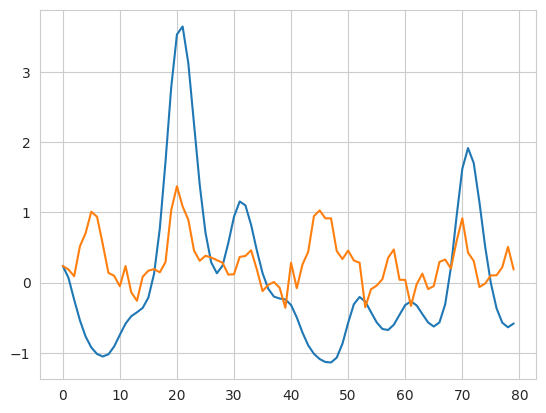

In [33]:
plt.plot(new_class_test.data.yval[2])
plt.plot(new_class_test.yval[2])

In [42]:
((new_class_test.data.yval[0]-new_class_test.yval[0])**2).mean()

0.9011071450467693

In [35]:
len(new_class_test.data.yval)

15

In [43]:
new_class_test.reinterpret_with_inputs()
print('res + inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_with_inputs(resume=False)
print('res + inputs val',np.sqrt(new_class_test.mse_val))

Loaded counts from file
res + inputs train 1.1530112915740387
res + inputs val 0.9273076631848817


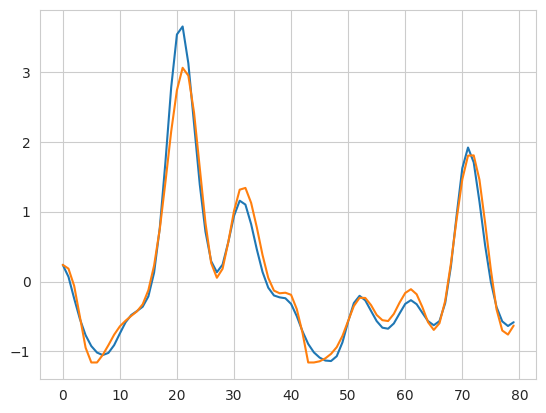

In [44]:
plt.plot(new_class_test.data.yval[2])
plt.plot(new_class_test.yval[2])

In [46]:
np.concatenate([(new_class_test.data.yval[i]-new_class_test.data.yval[i])**2 for i in range(15)]**2)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [54]:
np.sqrt(np.vstack([(new_class_test.yval[i]-new_class_test.data.yval[i])**2 for i in range(15)]).mean())

0.22354524917045332

In [56]:
np.round(new_class_test.weights.coef_,2)

array([[-0.03,  0.1 , -0.  ,  0.09, -0.1 , -0.02,  0.07,  0.08,  0.03,
        -0.06,  0.  ,  0.06,  0.  , -0.01, -0.04,  0.12,  0.09,  0.05,
         0.02, -0.02,  0.05, -0.01,  0.03, -0.09,  0.09, -0.  ,  0.03,
        -0.07,  0.05, -0.01, -0.01,  0.  , -0.01,  0.09, -0.04,  0.06,
         0.13, -0.11,  0.05, -0.1 ,  0.16,  0.  ,  0.  ,  0.02, -0.03,
         0.07, -0.08,  0.03,  0.03, -0.  , -0.21, -0.02, -0.03, -0.18,
        -0.02,  0.06,  0.01, -0.06,  0.04,  0.09, -0.08, -0.02, -0.  ,
        -0.03, -0.07,  0.11, -0.  ,  0.35,  0.11,  0.07,  0.08, -0.11,
        -0.03,  0.02,  0.01,  0.11,  0.12,  0.11,  0.02,  0.02, -0.05,
         0.05, -0.06,  0.17,  0.12,  0.03,  0.08,  0.05,  0.19, -0.02,
         0.  ,  0.06, -0.05,  0.08,  0.01, -0.1 , -0.03,  0.07, -0.  ,
        -0.02, -0.06,  1.16,  0.12,  0.09, -0.03,  0.06, -0.29, -0.99,
         0.38,  1.68]])

In [57]:
new_class_test.reinterpret_only_inputs()
print('only inputs train',np.sqrt(new_class_test.mse_train))

new_class_test.val_only_inputs(resume=False)
print('only inputs val',np.sqrt(new_class_test.mse_val))

Loaded counts from file
only inputs train 1.1522977181022431
only inputs val 0.8060372406580408


In [58]:
np.sqrt(np.vstack([(new_class_test.yval[i]-new_class_test.data.yval[i])**2 for i in range(15)]).mean())

0.367539475796646

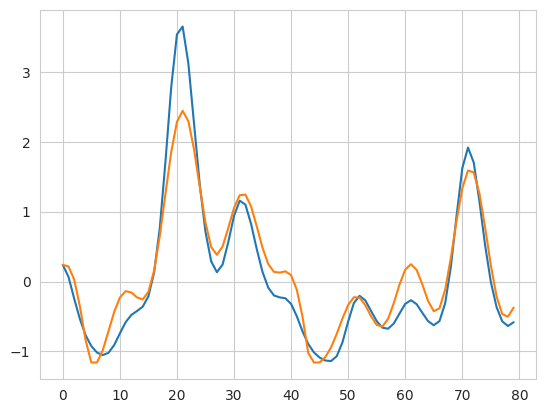

In [59]:
plt.plot(new_class_test.data.yval[2])
plt.plot(new_class_test.yval[2])

In [60]:
new_class_test.use_unnormed_error_metrics

True

In [5]:
new_class_test.data.__dict__

{'xtype': 'narma_smooth',
 'ytype': 'narma2',
 'memory': 2,
 'nepisodes': 2,
 'nvalepisodes': 15,
 'nepisodes_tt': 17,
 'steps': 80,
 'dimx': 1,
 'dimy': 1,
 'rseed_data': 0,
 'train_equal_val': False,
 'xtrain': [array([[-0.40790768],
         [ 0.04220037],
         [ 0.36290014],
         [ 0.46850708],
         [ 0.36607015],
         [ 0.14574429],
         [-0.06116005],
         [-0.13956371],
         [-0.04072137],
         [ 0.19478947],
         [ 0.45051764],
         [ 0.57923579],
         [ 0.46255507],
         [ 0.06207197],
         [-0.55804226],
         [-1.24651181],
         [-1.81368516],
         [-2.09610229],
         [-2.01332241],
         [-1.59608981],
         [-0.97541303],
         [-0.33654691],
         [ 0.14520852],
         [ 0.36338743],
         [ 0.31260963],
         [ 0.0830324 ],
         [-0.17994165],
         [-0.33469576],
         [-0.29836743],
         [-0.07684021],
         [ 0.24134057],
         [ 0.52424819],
         [ 0.6533560

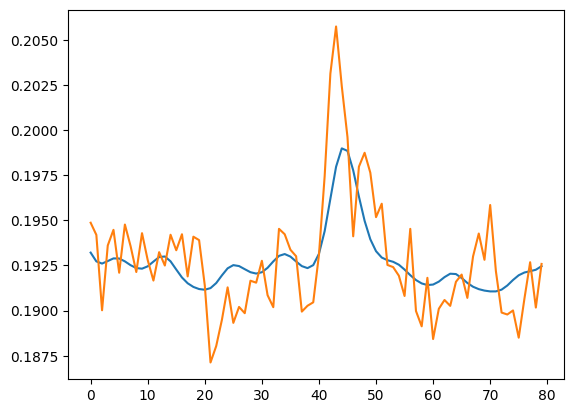

In [7]:
plt.plot(new_class_test.data.ytrain_nonorm[0])
plt.plot(new_class_test.ytrain_nonorm[0])

In [12]:
new_class_test.data.ymax_nonorm

[1]

In [8]:
print(new_class_test.data.ymin_nonorm, new_class_test.data.ymax_nonorm)

[0] [1]


In [6]:
new_class_test.data.ynorm == 'norm' or new_class_test.data.ynorm == 'std'

True

In [63]:
datat= DataSource(nepisodes=2, xtype='narma_smooth', ytype='narma2', memory=2, rseed_data=0,xnorm='std',ynorm='std')

Mean: 0.099567, StandardDeviation: 0.035614
Mean: 0.192841, StandardDeviation: 0.001545


In [70]:
print('x unnorm',datat.xmin_nonorm,datat.xmax_nonorm,'y unnorm',datat.ymin_nonorm,datat.ymax_nonorm)
print('x norm',datat.xmin,datat.xmax,'y unnorm',datat.ymin,datat.ymax)

x unnorm [0] [0.5] y unnorm [0] [1]
x norm [-2.6861692010791853] [2.7499161551753546] y unnorm [-1.1576956860874448] [4.328065936767971]


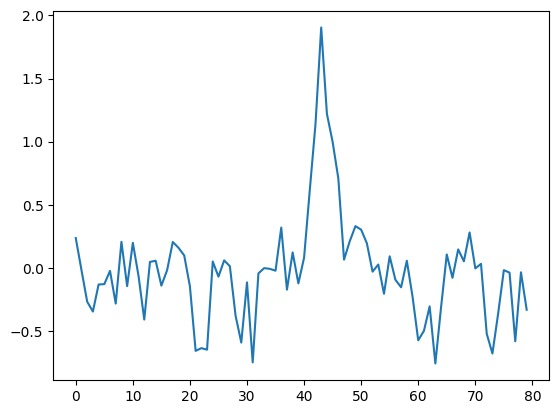

In [13]:
plt.plot(new_class_test.ytrain_nonorm[0])

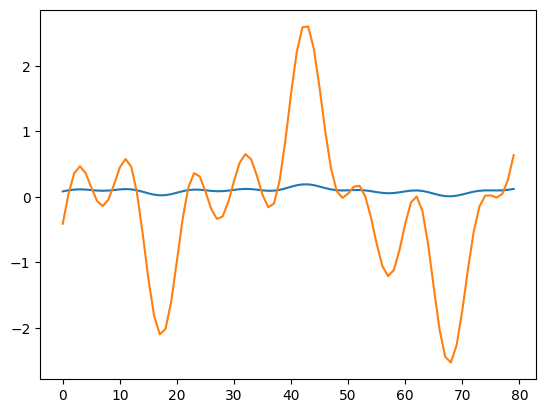

In [10]:
plt.plot(new_class_test.data.xtrain_nonorm[0])


In [11]:
data = DataSource(nepisodes=2, xtype='narma_smooth', ytype='narma2', memory=2, rseed_data=0,xnorm='norm',ynorm='norm')

In [15]:
data.xmin_nonorm

[0]

In [19]:
data.ymin_nonorm

[0.19105216293518507]

In [20]:
new_class_test.prepare(data)
new_class_test.train(resume=False)
print('res only train',np.sqrt(new_class_test.mse_train))

new_class_test.val(resume=False)
print('res only val',np.sqrt(new_class_test.mse_val))

Using Hard-coded layout
transpiled circuits 0.5
saved circuits
res only train 0.0017808217773691156
res only val 0.001525028332621203


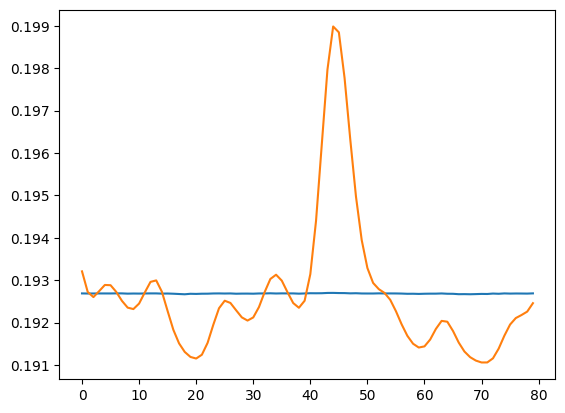

In [21]:
plt.plot(new_class_test.ytrain_nonorm[0])
plt.plot(new_class_test.data.ytrain_nonorm[0])

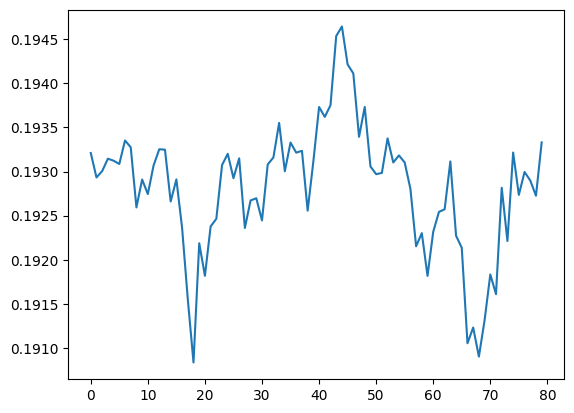

In [25]:
plt.plot(new_class_test.ytrain[0])